In [1]:
import yahoo_fin.stock_info as si
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn


In [22]:
### Configs

# Data
start_date = "01/01/2001"
end_date = "06/30/2023"
lookback = 60
window = 5
batch_size = 32

test_start_date = "07/01/2023"
test_end_date = "12/30/2023"


# Training
hidden_dim = 32
output_dim = 1
num_layers = 2

lr = 1e-4
num_epochs = 500
early_stopping_patience = 20

In [5]:
def get_stock_df(ticker, start_date, end_date, column="close", lookback=60, window=5):
    """Get stock price return for a given ticker and date range. 
    Apply a moving average filter and compute lagged returns.

    Args:
        ticker (str): Stock name
        start_date (str): Start date in format MM/DD/YYYY
        end_date (str): End date in format MM/DD/YYYY
        lookback (int, optional): Lookback period for lagged features. Defaults to 60.
        window (int, optional): Window size for moving average filter. Defaults to 5.
    """
    
    data_start_date = (pd.to_datetime(start_date) - pd.DateOffset(days=int(lookback*2))).date().strftime('%m/%d/%Y')
    df = si.get_data(ticker, start_date=data_start_date, end_date=end_date)[[column]]
    
    # get the first open date
    start_date = df.index[df.index >= start_date][0]
    
    # compute returns and moving average
    df_returns = df.pct_change().dropna()

    df_returns["rolling"] = df_returns.rolling(window).mean()
    
    df_returns["target"] = (df_returns.close > 0).astype(int)
    df = (df_returns[["target", "rolling"]].dropna())
    
    # create lagged features
    data = pd.concat([df] + [df["rolling"].shift(i) for i in range(1, lookback)], axis=1)
    data = data[data.index >= start_date]
    
    # rename columns
    data.columns = ["target"] + ["lag_{}".format(i) for i in range(lookback)]
    data = data.iloc[:, ::-1]
    data.target = (data.target > 0).astype(int)
    
    return data


def get_X_y(train):
    y = train["target"]
    X = train.drop(["target"], axis=1)
    return X, y

def split_data(train, test_size=0.2):
    n = int(len(train) * (1 - test_size))
    X_train, y_train = get_X_y(train[:n])
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    
    X_val, y_val = get_X_y(train[n:])
    X_val = scaler.transform(X_val)
    
    return (X_train, y_train, X_val, y_val), scaler

In [6]:
# create dataframe

train = get_stock_df("AAPL", start_date, end_date, lookback=lookback, window=window)
train

,lag_59,lag_58,lag_57,lag_56,lag_55,lag_54,lag_53,lag_52,lag_51,lag_50,...,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0,target
2001-01-02,-0.027960,-0.020253,-0.012319,-0.036060,-0.019011,0.000481,-0.000674,-0.005419,0.006557,-0.009066,...,-0.018415,-0.008180,-0.005028,0.013500,0.006668,0.011878,0.006521,0.011713,-0.001621,0
2001-01-03,-0.020253,-0.012319,-0.036060,-0.019011,0.000481,-0.000674,-0.005419,0.006557,-0.009066,-0.023751,...,-0.008180,-0.005028,0.013500,0.006668,0.011878,0.006521,0.011713,-0.001621,0.022714,1
2001-01-04,-0.012319,-0.036060,-0.019011,0.000481,-0.000674,-0.005419,0.006557,-0.009066,-0.023751,-0.009677,...,-0.005028,0.013500,0.006668,0.011878,0.006521,0.011713,-0.001621,0.022714,0.029409,1
2001-01-05,-0.036060,-0.019011,0.000481,-0.000674,-0.005419,0.006557,-0.009066,-0.023751,-0.009677,-0.011610,...,0.013500,0.006668,0.011878,0.006521,0.011713,-0.001621,0.022714,0.029409,0.021350,0
2001-01-08,-0.019011,0.000481,-0.000674,-0.005419,0.006557,-0.009066,-0.023751,-0.009677,-0.011610,-0.015584,...,0.006668,0.011878,0.006521,0.011713,-0.001621,0.022714,0.029409,0.021350,0.022797,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-23,0.003758,0.004343,0.005810,0.009809,0.009955,0.003739,0.002860,-0.003463,-0.006522,-0.006742,...,0.004689,0.004579,0.006829,0.005975,0.004371,0.001341,0.000728,0.003335,0.000753,0
2023-06-26,0.004343,0.005810,0.009809,0.009955,0.003739,0.002860,-0.003463,-0.006522,-0.006742,0.002337,...,0.004579,0.006829,0.005975,0.004371,0.001341,0.000728,0.003335,0.000753,0.000414,0
2023-06-27,0.005810,0.009809,0.009955,0.003739,0.002860,-0.003463,-0.006522,-0.006742,0.002337,0.000815,...,0.006829,0.005975,0.004371,0.001341,0.000728,0.003335,0.000753,0.000414,0.003329,1
2023-06-28,0.009809,0.009955,0.003739,0.002860,-0.003463,-0.006522,-0.006742,0.002337,0.000815,0.004033,...,0.005975,0.004371,0.001341,0.000728,0.003335,0.000753,0.000414,0.003329,0.005730,1


In [7]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(30, 10))

# ax.plot(df_returns["close"], lw=1, label="close")
# ax.plot(df_returns["rolling"], lw=1, label="rolling")
# ax.set_ylabel("Returns")
# ax.set_xlabel("Date")

# plt.legend()
# plt.show()

In [8]:
(X_train, y_train, X_val, y_val), scaler = split_data(train)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(2), torch.tensor(y_train, dtype=torch.float32).flatten())
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32).unsqueeze(2), torch.tensor(y_val, dtype=torch.float32).flatten())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)    # why shuffle = True? (to avoid overfitting)
val_loader = DataLoader(val_dataset, batch_size=batch_size*4, shuffle=False)

assert train_dataset.tensors[0].shape[1] == lookback

C:\Users\jiumi\AppData\Local\Temp\ipykernel_39848\2404421021.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).unsqueeze(2), torch.tensor(y_train, dtype=torch.float32).flatten())
C:\Users\jiumi\AppData\Local\Temp\ipykernel_39848\2404421021.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32).unsqueeze(2), torch.tensor(y_val, dtype=torch.float32).flatten())


In [ ]:
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(StockLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out
    

def validate(test_loader):
    val_losses = []
    val_accs = []
    model.eval()
    with torch.no_grad():
        for X_batch_t, y_batch_t in test_loader:
            y_val_pred = model(X_batch_t).squeeze()
            val_loss = loss_fn(y_val_pred, y_batch_t)
            val_acc = ((y_val_pred > 0.5) == y_batch_t).sum().item() / len(y_batch_t)
            val_losses.append(val_loss.item())
            val_accs.append(val_acc)
    model.train()
    return np.mean(val_losses), np.mean(val_accs)

In [12]:
from tqdm import tqdm
import numpy as np


# Define Model
model = StockLSTM(input_dim=1, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = nn.BCELoss()
# loss_fn = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=5, verbose=True, )

history = np.zeros((num_epochs, len(train_loader)))
val_losses = []
min_val_loss = np.inf
min_val_loss_epoch = -1
best_model = None

# seed everything
torch.manual_seed(7)
np.random.seed(7)


for t in range(num_epochs):
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (X_batch, y_batch) in pbar:
            y_pred = model(X_batch).squeeze()
            loss = loss_fn(y_pred, y_batch)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            
            if i % 10 == 0 and i != 0:
                pbar.set_description(f"Epoch {t}, MSE: {loss.item():.4f}")
            history[t, i] = loss.item()
            
        val_loss_epoch, val_acc_epoch = validate(val_loader)
        pbar.set_postfix(val_loss=val_loss_epoch, val_acc=val_acc_epoch)
        pbar.refresh()
        val_losses.append(val_loss_epoch)
        # lr_scheduler.step(val_loss_epoch)
        
    # Early stopping
    if val_loss_epoch < min_val_loss:
        min_val_loss = val_loss_epoch
        min_val_loss_epoch = t
        best_model = model.state_dict()
    
    elif t - min_val_loss_epoch > early_stopping_patience:
        print(f"Stopping early at epoch {t}")
        break

# Load best model
model.load_state_dict(best_model)

Epoch 274, MSE: 0.1742: 100%|██████████| 142/142 [00:00<00:00, 188.14it/s]


Stopping early at epoch 274


<All keys matched successfully>

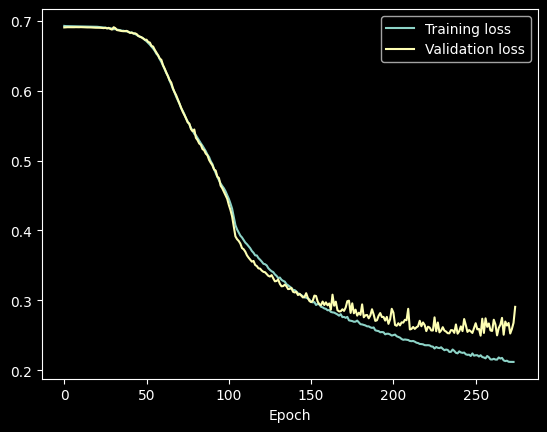

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.mean(axis=1)[:t], label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epoch")

plt.legend()
plt.show()

In [26]:
test = get_stock_df("AAPL", test_start_date, test_end_date, lookback=lookback, window=window)

X_test, y_test = get_X_y(test)
X_test = scaler.transform(X_test)

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())
test_loader = DataLoader(test_dataset, batch_size=batch_size*4, shuffle=False)

test_losses = []
test_accs = []
with torch.no_grad():
    for X_batch_t, y_batch_t in test_loader:
        y_test_pred = model(X_batch_t).squeeze()
        test_loss = loss_fn(y_test_pred, y_batch_t)
        test_acc = ((y_test_pred > 0.5) == y_batch_t).sum() / len(y_batch_t)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc.item())
        
test_loss = np.mean(test_losses)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {np.mean(test_accs):.4f}")

Test loss: 0.2724
Test accuracy: 0.8889


C:\Users\jiumi\AppData\Local\Temp\ipykernel_39848\2637509498.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32).unsqueeze(2), torch.tensor(y_test, dtype=torch.float32).flatten())
